# Review of classical electronic structure methods 

In order to assess the performance of quantum computing algorithms in addressing the electronic structure problem, we will briefly review a few commonly employed classical electronic structure methods of varying level of approximation. 

## Hartree-Fock

The Hartree-Fock (HF) method employs a **mean-field approximation**, where Coulomb correlation of electrons is neglected. The HF wavefunction is hence restricted to the form of a single Slater determinant, for which the optimal form may be acquired by an optimization of the underlying single particle basis (orbitals). Once the optimal HF orbitals have been found, the HF state may be written as 

$$ | \text{HF} \rangle = \prod_{p \in \text{occ}} \hat a^\dagger_p | \text{vac} \rangle $$

where $\hat a^\dagger_p$ creates an electron in the $p^{\rm{th}}$ optimized HF spin orbital, and  $| \text{vac} \rangle$ is the vacuum state (all spin-orbitals unoccupied). Due to the restriction to a single Slater determinant, the HF energy may be obtained very efficiently and can be applied to very large molecules, however it becomes qualitatively incorrect when **electronic correlations** become sufficiently strong. The HF wavefunction is often used as a starting point in more accurate treatments of electronic correlation. 

## Coupled cluster

The Coupled cluster (CC) method introduces electronic correlation to the wavefunction ansatz by operating on the HF reference state with the exponential of excitation operators

$$|\text{CC} \rangle = e^{\hat T} | \text{HF}\rangle, \quad \hat T = \hat T_1 + \hat T_2 + ...$$

where $\hat T_1 = \sum_{ia} t^{a}_i \hat a^\dagger_a \hat a_i$ are referred to as 'singles', $\hat T_2 = \sum_{ijab} t^{ab}_{ij} \hat a^\dagger_a \hat a^\dagger_b \hat a_i \hat a_j$ as 'doubles', etc. When the excitation rank is truncated to only singles (S) and doubles (D), $\hat T = \hat T_1 + \hat T_2$, the corresponding ansatz is referred to as CCSD. Since the number of possible single and double excitations for a system of $N$ electrons in $M$ orbitals is polynomial in $M$, one can efficiently solve a system of equations to obtain the optimized CCSD amplitudes. CCSD often gives accurate energies and can be applied to modestly sized chemical systems. However, due to its implementation, it can **violate the variational principle** and give energies lower than the ground state.

## Full Configuration Interaction
The full configuration interaction (FCI) method yields the **exact ground state energy** within a given basis set. The FCI wavefunction is written as a linear combination of all possible $N$-particle Slater determinants over the orbital basis
$$|\text{FCI} \rangle =  \left( \sum_{ia} C^{a}_i \hat a^\dagger_a \hat a_i + \sum_{ijab} C^{ab}_{ij} \hat a^\dagger_a \hat a^\dagger_b \hat a_i \hat a_j + ...  \right) | \text{HF} \rangle $$
where the sum includes up to $N$-electron excitations, and hence there are an exponential number of coefficients to optimize in $| \text{FCI} \rangle$. Due to its **exponential complexity**, FCI is often reserved for only the smallest chemical systems. However, it serves as a useful result to compare to when assessing tractable electronic structure methods.

# Benchmarking for electronic PESs in minimal basis (STO-3G)

We will apply HF, CCSD, and FCI to obtaining the PESs for a few molecular dissociation processes in minimal (STO-3G) basis.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from utility import get_molecular_data, obtain_PES
import time
import pandas as pd

/home/abarthe/.local/lib/python3.7/site-packages/pyscf/lib/misc.py:46: H5pyDeprecationWarning: Using default_file_mode other than 'r' is deprecated. Pass the mode to h5py.File() instead.
  h5py.get_config().default_file_mode = 'a'


In [2]:
class benchmark:
    def __init__(self,list_molecules=['h2'], list_basis=['sto-3g'], list_methods=['fci'],bond_lengths = np.linspace(0.2,2.6,15)):
        self.list_molecules = list_molecules
        self.list_basis = list_basis
        self.list_methods = list_methods
        self.bond_lengths = bond_lengths
        
        self.times = np.zeros((len(list_molecules),len(list_basis),len(list_methods)))
        self.results=np.zeros((len(list_molecules),len(list_basis),len(list_methods),len(bond_lengths)))
    
    def compute_all(self):
        for i_m,m in enumerate(self.list_molecules):
            print(f'{i_m+1} molecule out of {len(self.list_molecules)}')
            for i_b,b in enumerate(self.list_basis):
                print(f'{i_b+1} basis out of {len(self.list_basis)}')
                for i_f,f in enumerate(self.list_methods):
                    print(f'{i_f+1} method out of {len(self.list_methods)}')
                    tic = time.time()
                    self.results[i_m,i_b,i_f,:] = obtain_PES([m], self.bond_lengths, b, method=f)
                    toc = time.time()
                    self.times[i_m,i_b,i_f]= toc-tic                   
            
    
    def plot_all(self,i_b):
        
        colors = ['orange','purple','yellow','green']
        N = len(self.list_molecules)
        L = 3
        K = int(N/L) + 1 

        fig, axs = plt.subplots(K, L,figsize=(15,5))

        for i_m in range(N):
            ax = axs[i_m]

            ax.plot(self.bond_lengths, self.results[i_m,i_b,0,:], label=self.list_methods[0],color='k')
            s=15 
            for i_f in range(1,len(self.list_methods)):
                ax.scatter(self.bond_lengths, self.results[i_m,i_b,i_f,:], label=self.list_methods[i_f], color=colors[i_f-1],s=s)
                s*=0.9

            ax.set_title(f'{self.list_molecules[i_m]} dissociation, {self.list_basis[i_b]}')
            ax.set_xlabel('R, Angstrom')
            ax.set_ylabel('E, Hartree')
            ax.legend()
    
    def print_times(self,i_b):
        print('Duration of computation in seconds')
        T = np.squeeze(self.times[:,i_b,:])
        df = pd.DataFrame(T, index =self.list_molecules,columns =self.list_methods)
        return df
    

In [3]:
bond_lengths = np.linspace(0.2,2.6,15)
basis = 'sto-3g'

## H<sub>2</sub>

In [8]:
#Run FCI
FCI_PES = obtain_PES(['h2'], bond_lengths, basis, method='fci')
HF_PES = obtain_PES(['h2'], bond_lengths, basis,  method='hf')
CCSD_PES = obtain_PES(['h2'], bond_lengths, basis,  method='ccsd')
CISD_PES = obtain_PES(['h2'], bond_lengths, basis,  method='cisd')

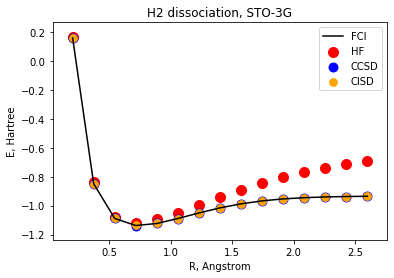

In [16]:
#Plot H2 PESs

plt.title('H2 dissociation, STO-3G')
plt.xlabel('R, Angstrom')
plt.ylabel('E, Hartree')

plt.plot(bond_lengths, FCI_PES, label='FCI',color='black')
plt.scatter(bond_lengths, HF_PES, label='HF', color='red',s=100)
plt.scatter(bond_lengths, CCSD_PES, label='CCSD', color='blue',s=80)
plt.scatter(bond_lengths, CISD_PES, label='CISD', color='orange',s=60)
plt.legend()

# LiH

In [17]:
#Run FCI
FCI_PES = obtain_PES(['lih'], bond_lengths, basis, method='fci')
HF_PES = obtain_PES(['lih'], bond_lengths, basis,  method='hf')
CCSD_PES = obtain_PES(['lih'], bond_lengths, basis,  method='ccsd')
CISD_PES = obtain_PES(['lih'], bond_lengths, basis,  method='cisd')

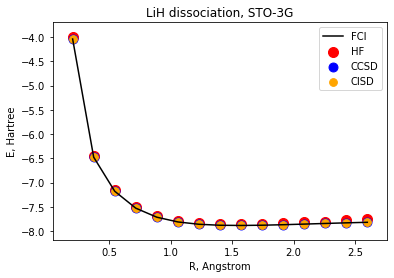

In [18]:
#Plot H2 PESs

plt.title('LiH dissociation, STO-3G')
plt.xlabel('R, Angstrom')
plt.ylabel('E, Hartree')

plt.plot(bond_lengths, FCI_PES, label='FCI',color='black')
plt.scatter(bond_lengths, HF_PES, label='HF', color='red',s=100)
plt.scatter(bond_lengths, CCSD_PES, label='CCSD', color='blue',s=80)
plt.scatter(bond_lengths, CISD_PES, label='CISD', color='orange',s=60)
plt.legend()

## H2O

In [19]:
#Run FCI
FCI_PES = obtain_PES(['lih'], bond_lengths, basis, method='fci')
HF_PES = obtain_PES(['lih'], bond_lengths, basis,  method='hf')
CCSD_PES = obtain_PES(['lih'], bond_lengths, basis,  method='ccsd')
CISD_PES = obtain_PES(['lih'], bond_lengths, basis,  method='cisd')

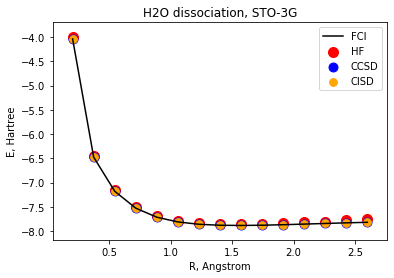

In [20]:
#Plot H2 PESs

plt.title('H2O dissociation, STO-3G')
plt.xlabel('R, Angstrom')
plt.ylabel('E, Hartree')

plt.plot(bond_lengths, FCI_PES, label='FCI',color='black')
plt.scatter(bond_lengths, HF_PES, label='HF', color='red',s=100)
plt.scatter(bond_lengths, CCSD_PES, label='CCSD', color='blue',s=80)
plt.scatter(bond_lengths, CISD_PES, label='CISD', color='orange',s=60)
plt.legend()

# H4

In [21]:
#Run FCI
FCI_PES = obtain_PES(['h4'], bond_lengths, basis, method='fci')
HF_PES = obtain_PES(['h4'], bond_lengths, basis,  method='hf')
CCSD_PES = obtain_PES(['h4'], bond_lengths, basis,  method='ccsd')
CISD_PES = obtain_PES(['h4'], bond_lengths, basis,  method='cisd')

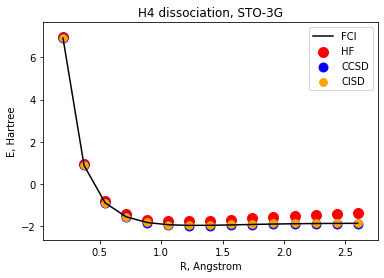

In [22]:
#Plot H2 PESs

plt.title('H4 dissociation, STO-3G')
plt.xlabel('R, Angstrom')
plt.ylabel('E, Hartree')

plt.plot(bond_lengths, FCI_PES, label='FCI',color='black')
plt.scatter(bond_lengths, HF_PES, label='HF', color='red',s=100)
plt.scatter(bond_lengths, CCSD_PES, label='CCSD', color='blue',s=80)
plt.scatter(bond_lengths, CISD_PES, label='CISD', color='orange',s=60)
plt.legend()

# NH3

In [ ]:
#Run FCI
FCI_PES = obtain_PES(['nh3'], bond_lengths, basis, method='fci')
HF_PES = obtain_PES(['nh3'], bond_lengths, basis,  method='hf')
CCSD_PES = obtain_PES(['nh3'], bond_lengths, basis,  method='ccsd')
CISD_PES = obtain_PES(['nh3'], bond_lengths, basis,  method='cisd')

In [ ]:
#Plot H2 PESs

plt.title('NH3 dissociation, STO-3G')
plt.xlabel('R, Angstrom')
plt.ylabel('E, Hartree')

plt.plot(bond_lengths, FCI_PES, label='FCI',color='black')
plt.scatter(bond_lengths, HF_PES, label='HF', color='red',s=100)
plt.scatter(bond_lengths, CCSD_PES, label='CCSD', color='blue',s=80)
plt.scatter(bond_lengths, CISD_PES, label='CISD', color='orange',s=60)
plt.legend()

# N2

In [ ]:
#Run FCI
FCI_PES = obtain_PES(['n2'], bond_lengths, basis, method='fci')
HF_PES = obtain_PES(['n2'], bond_lengths, basis,  method='hf')
CCSD_PES = obtain_PES(['n2'], bond_lengths, basis,  method='ccsd')
CISD_PES = obtain_PES(['n2'], bond_lengths, basis,  method='cisd')

In [ ]:
#Plot H2 PESs

plt.title('N2 dissociation, STO-3G')
plt.xlabel('R, Angstrom')
plt.ylabel('E, Hartree')

plt.plot(bond_lengths, FCI_PES, label='FCI',color='black')
plt.scatter(bond_lengths, HF_PES, label='HF', color='red',s=100)
plt.scatter(bond_lengths, CCSD_PES, label='CCSD', color='blue',s=80)
plt.scatter(bond_lengths, CISD_PES, label='CISD', color='orange',s=60)
plt.legend()